![Alt text](illustrations/header3.png)

In [50]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import shutil

from IPython.display import display, Image
import PIL
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import time
import concurrent.futures
import warnings
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

<div style="background-color: #0B132B; padding: 25px; border-radius: 8px; border: 2px solid #6FFFE9; margin-top: 0;">
    <h3 style="color: #5BC0BE; text-align: center; font-size: 26px; margin-top: 30; margin-bottom: 30">Brief Description of the Problem and Data</h3>
</div>

In this final project, we will try to classify architectural heritage. More specifically, we want to create a Convolutional Neural Network (CNN) that can classify architectural heritage elements into classes, such as altar, apse, bell tower, column, dome (inner), dome (outer), flying buttress, gargoyle, stained glass and vault. We will try out different types of neural network architectures and hyper parameter tuning, to gain insight into what factors most affect model performance.

The project is inspired by the article ‘Classification of Architectural Heritage Images Using Deep Learning Techniques’ by Llamas et al. (2017). In this article, the authors try out several CNN models – which were state-of-the-art at the time of publication – to classify architectural heritage elements. The dataset that this project uses is (almost) the same the dataset used by the article authors, which they created and made available as part of the publication project. The dataset can be found several places and in several versions. However, the dataset used in this project was downloaded from https://correo.cartif.es/home/joslla@cartif.es/Briefcase/Architectural_Heritage_Elements_image_Dataset  

The aim of this final project is somewhat different from the aforementioned article. While the aim of the article was to investigate how well state-of-the-art models could classify architectural heritage elements, this project wants to explore how different network architectures and hyper parameter tuning affect performance. Nevertheless, we will also at the end of the notebook compare how our best performing model compares to the worst (AlexNet) and the best (Inception-ResNet-v2) performing models in the article.

**References**

Llamas J, M. Lerones P, Medina R, Zalama E, Gómez-García-Bermejo J. Classification of Architectural Heritage Images Using Deep Learning Techniques. Applied Sciences. 2017; 7(10):992. https://doi.org/10.3390/app7100992

<div style="background-color: #0B132B; padding: 25px; border-radius: 8px; border: 2px solid #6FFFE9; margin-top: 0;">
    <h3 style="color: #5BC0BE; text-align: center; font-size: 26px; margin-top: 30; margin-bottom: 30">Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data</h3>
</div>

In this section, we will ...
* provide a quantitative overview of the data, which shows how many images there are in each category
* Visually inspect a few images and verify that they look fine.
* Verify that the images are of the same shape (128 x 128 x 3)
* Based on the analysis above, we will desceide on some measurement to make the dataset suitable for CNN-modelling

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Useful functions</h3>
</div>

In [9]:
def display_sample_images(directory, seed=42):
    """
    Displays one randomly selected image from each subdirectory in the given directory,
    with the subdirectory name displayed as the header of the image. Arranges images with 4 on the top two rows and 3 on the last row, with no visible axes.
    The function uses a random seed for reproducibility.

    Parameters:
    - directory (str): Path to the directory containing the subdirectories.
    - seed (int): Seed value for random number generator to ensure reproducibility.
    """
    random.seed(seed)  # Initialize the random number generator with the seed

    # List subdirectories
    directories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

    # Calculate the number of rows and columns
    num_images = len(directories)
    num_rows = 3
    num_cols = 4

    # Set up the figure for plotting
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))  # Set up a grid of 3x4 for the plots
    axs = axs.ravel()  # Flatten the axis array for easier iteration

    # Initially turn off all axes
    for ax in axs:
        ax.axis('off')
    
    # Process each subdirectory and display images
    for i, dir_name in enumerate(directories):
        if i < num_images:
            path = os.path.join(directory, dir_name)
            images = [img for img in os.listdir(path) if img.endswith(('.jpg', '.png'))]  # Adjust formats as necessary
            
            if images:
                selected_image = random.choice(images)  # Select a random image
                img_path = os.path.join(path, selected_image)
                img = PIL.Image.open(img_path)  # Open the image using PIL.Image
                
                # Display the image
                axs[i].imshow(img)
                axs[i].set_title(dir_name)  # Set the directory name as the title
                axs[i].axis('off')  # Keep axis off to only show the image

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

In [10]:
def check_image_shapes_against_target(folder_path, target_shape):
    """
    Checks the shapes of all images in the specified folder against a target shape and returns a list of boolean values.

    Parameters:
    - folder_path (str): Path to the folder containing the images.
    - target_shape (tuple): A tuple containing the target (height, width, num_channels).

    Returns:
    - List of boolean: Each element is True if the corresponding image matches the target shape, False otherwise.
    """
    # Get all image files from the folder
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    match_results = []
    for image_file in image_files:
        img_path = os.path.join(folder_path, image_file)  # Construct the full path to the image
        
        # Open the image and get its properties
        with PIL.Image.open(img_path) as img:
            width, height = img.size
            num_channels = len(img.getbands())
            current_shape = (height, width, num_channels)
            
            # Compare current image shape with the target shape
            match_results.append(current_shape == target_shape)

    return match_results



def find_non_conforming_images(folder_path, target_shape):
    """
    Identifies images in the specified folder that do not match a target shape and returns their filenames.

    Parameters:
    - folder_path (str): Path to the folder containing the images.
    - target_shape (tuple): A tuple containing the target (height, width, num_channels).

    Returns:
    - List of str: Filenames of images that do not match the target shape.
    """
    # Get all image files from the folder
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    non_conforming_files = []
    for image_file in image_files:
        img_path = os.path.join(folder_path, image_file)  # Construct the full path to the image
        
        # Open the image and get its properties
        with PIL.Image.open(img_path) as img:
            width, height = img.size
            num_channels = len(img.getbands())
            current_shape = (height, width, num_channels)
            
            # Add the file to the list if it does not match the target shape
            if current_shape != target_shape:
                non_conforming_files.append(image_file)

    return non_conforming_files

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Investigation</h3>
</div>

In [11]:
# The Number of images in the dataset by category
directories = [directory for directory in os.listdir('Architectural_Heritage_Elements_Dataset_128') if directory != '.DS_Store']
number_of_files = list()

for directory in directories:
    number_of_files.append(len(os.listdir('Architectural_Heritage_Elements_Dataset_128/' + directory)))

data = zip(directories, number_of_files)
df_files = pd.DataFrame(data, columns=['Directory', 'Number of Files'])
df_files

,Directory,Number of Files
0,bell_tower,1059
1,dome(outer),1177
2,gargoyle,1571
3,portal,308
4,flying_buttress,407
5,dome(inner),616
6,stained_glass,1033
7,column,1919
8,apse,514
9,vault,1110


In [12]:
# Total number of files
num_files_tot = df_files['Number of Files'].sum()
print(f"The total number of files are: {num_files_tot}")

The total number of files are: 10543


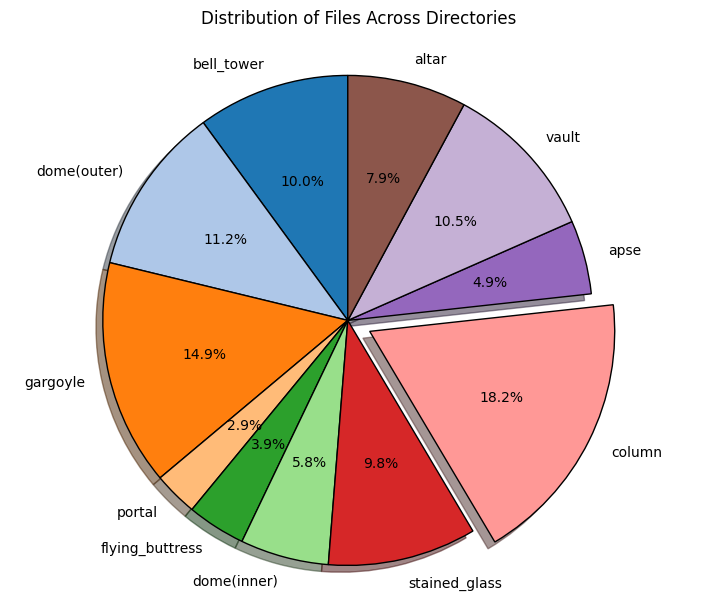

In [13]:
# Improved color palette from the tab20 colormap, ensuring good visibility
colors = plt.cm.tab20.colors  # This uses a tabulated colormap with 20 unique colors

# Create a pie chart with additional visual enhancements
plt.figure(figsize=(9, 7))  # Adjust the figure size as needed to make it more prominent
# Explode the largest slice for emphasis
explode = [0.1 if i == df_files['Number of Files'].idxmax() else 0 for i in range(len(df_files['Directory']))]
# Add shadow for a 3D effect
plt.pie(df_files['Number of Files'], labels=df_files['Directory'], autopct='%1.1f%%', startangle=90,
        colors=colors[:len(df_files['Directory'])], explode=explode, shadow=True, wedgeprops={'edgecolor': 'black'})

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Optional: add a title to the chart
plt.title('Distribution of Files Across Directories', pad=20)  # Added padding for better layout

# Show the plot
plt.show()


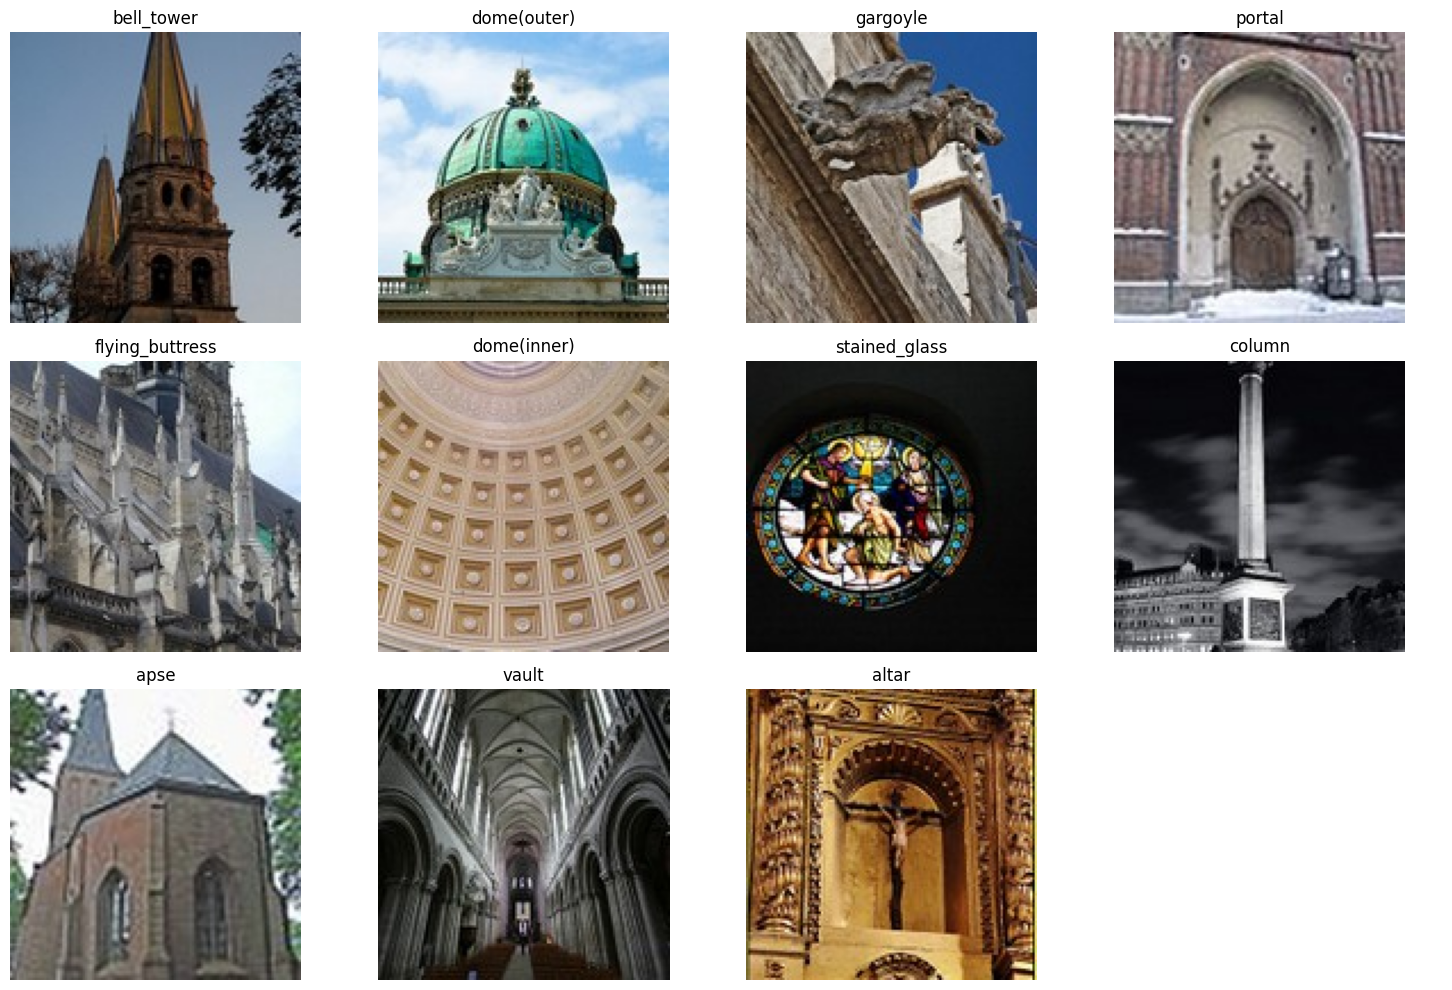

In [14]:
# Display sample images:
display_sample_images('Architectural_Heritage_Elements_Dataset_128')

In [15]:
for directory in directories:
    print(f"{directory: <16} ... All images are shape (128, 128, 3) ... {all(check_image_shapes_against_target(f'Architectural_Heritage_Elements_Dataset_128/{directory}', (128, 128, 3)))}")

bell_tower       ... All images are shape (128, 128, 3) ... True
dome(outer)      ... All images are shape (128, 128, 3) ... True
gargoyle         ... All images are shape (128, 128, 3) ... True
portal           ... All images are shape (128, 128, 3) ... True
flying_buttress  ... All images are shape (128, 128, 3) ... False
dome(inner)      ... All images are shape (128, 128, 3) ... True
stained_glass    ... All images are shape (128, 128, 3) ... True
column           ... All images are shape (128, 128, 3) ... True
apse             ... All images are shape (128, 128, 3) ... True
vault            ... All images are shape (128, 128, 3) ... True
altar            ... All images are shape (128, 128, 3) ... True


In [16]:
# Find non-conforming image
non_conforming_images = find_non_conforming_images('Architectural_Heritage_Elements_Dataset_128/flying_buttress', (128, 128, 3))
print("Non-conforming image files:", non_conforming_images)

Non-conforming image files: ['Le_Mont_Saint-Michel_en_1948_(9).jpg']


<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Conclusion</h3>
</div>

Based on our investigations, we can conclude that:

* The dataset consists of 11 categories of architectual heritage elements. This is one more category of heritage elements than in the original study. The extra catogory is portal. Since portal makes up such a small amount of the total dataset (2.9%), we will drop this category when we develop our model.
* There is one image in the flying bruttress category that does not conform to the 128 x 128 x 3 format - Le_Mont_Saint-Michel_en_1948_(9).jpg. It will not be used in our model building efforts.
* In total, there are a large amount of images (10543), which makes it easier to train the CNN. However, there are also a considerable number of possible categories (10), which makes it harder to create a model with a high level of accuracy. 

<div style="background-color: #0B132B; padding: 25px; border-radius: 8px; border: 2px solid #6FFFE9; margin-top: 0;">
    <h3 style="color: #5BC0BE; text-align: center; font-size: 26px; margin-top: 30; margin-bottom: 30">Model Architecture</h3>
</div>

We will in this section will try out four different CNN architectures:

* **Basic Architecture** with two combined sets of one convolution layer followed by one max pooling layers.
* **Deep Architecture** with three sets of one convolution layer followed by one max pooling layers.
* **Double Convolution Layer Architecture** with two sets of two convolution layers followed by one max pooling layer.
* **Double Deep Architecture** which has three sets of double convolution layers (combination of the two previous architectures).

The principle idea here is to see if we can improve the accuracy of our prediction by adopting specific architectural principles. Adding more layers to a CCN-model should enhance its capacity to learn more complex features from the data. We will test this theory by adopting the Deep Architecture. And adding double convolution layers should allow the network to perform more complex feature extraction before pooling and enable it to better recognize and combine detailed patterns within the input data. We will test that theory by adopting the Double Convolution Layer Architecture. In both cases, we will compare these models with a model that applies a simpler and less sophisticated architecture, which we will refer to as the Basic Architecture. Finally, we will test a Double Deep model that combines both extra layers and double convolution layers. See illustration below.

The models also share some common features. Each of these models will make use of a **dropout layer** before the output layer to add some regularization to the models. The models also apply the principle of **increasing number of filters** in the deeper layers of a convolutional neural network to be able to capture more complex and abstract features in the input data. For more on this topic see for instance Albelwi and Mahmood, 2017.

Since there is a limited amount of data for each category, we will only split the data into a training and validaiton set. Ideally, we would have compared the models using a separate test dataset, but that would have taken too many images out of the training set and adversely affected the model performance. Therefore, we compare the models using their validation scores.

In this section, we will exclusively focus on the architecture of the CNN and will not try to improve them using different optimizers or regularization techniques. We will do that in the next section after we have settled on a preferred architecture. 

**References**

Albelwi S, Mahmood A. A Framework for Designing the Architectures of Deep Convolutional Neural Networks. Entropy. 2017; 19(6):242. https://doi.org/10.3390/e19060242.

![Example Image](illustrations/architecture.png)

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Useful functions</h3>
</div>

In [17]:
def create_dataset(directory, output_directory, exclude_folder=None, exclude_image=None, train_size=0.6, val_size=0.2, test_size=0.2):
    """
    Creates a dataset divided into training, validation, and test sets from a directory of images,
    allowing for exclusion of specific folders and images. Outputs the dataset into a specified root folder.
    Can optionally exclude the test set by setting test_size to 0.

    Parameters:
    - directory (str): The root directory containing subdirectories for each class.
    - output_directory (str): The root directory where train, val, and (optionally) test directories will be created.
    - exclude_folder (str): Name of the folder to exclude from the dataset.
    - exclude_image (str): Filename of an image to exclude from the dataset.
    - train_size (float): Proportion of the dataset to include in the train split.
    - val_size (float): Proportion of the dataset to include in the validation split.
    - test_size (float): Proportion of the dataset to include in the test split.
    """
    # Setup directories for train and validation sets within the output directory
    train_dir = os.path.join(output_directory, 'train')
    val_dir = os.path.join(output_directory, 'val')
    
    # Create directories if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Optionally setup the directory for test set
    test_dir = None
    if test_size > 0:
        test_dir = os.path.join(output_directory, 'test')
        os.makedirs(test_dir, exist_ok=True)

    # Process each subdirectory in the main directory
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)

        if os.path.isdir(folder_path) and folder != exclude_folder:
            class_train_dir = os.path.join(train_dir, folder)
            class_val_dir = os.path.join(val_dir, folder)
            class_test_dir = os.path.join(test_dir, folder) if test_dir else None

            # Create class directories in train, val, and optionally test directories
            os.makedirs(class_train_dir, exist_ok=True)
            os.makedirs(class_val_dir, exist_ok=True)
            if class_test_dir:
                os.makedirs(class_test_dir, exist_ok=True)

            # Get all image files except the excluded one
            images = [img for img in os.listdir(folder_path) if img.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')) and img != exclude_image]

            # Check if there are any images to split
            if images:
                if test_size > 0:
                    # Split the images into train, val, and test
                    train_images, test_val_images = train_test_split(images, train_size=train_size + val_size, random_state=42)
                    val_images, test_images = train_test_split(test_val_images, test_size=test_size / (test_size + val_size), random_state=42)
                else:
                    # Split the images into just train and val
                    train_images, val_images = train_test_split(images, train_size=train_size / (train_size + val_size), random_state=42)

                # Copy images to their respective directories
                for img in train_images:
                    shutil.copy(os.path.join(folder_path, img), class_train_dir)
                for img in val_images:
                    shutil.copy(os.path.join(folder_path, img), class_val_dir)
                if test_size > 0 and test_images:
                    for img in test_images:
                        shutil.copy(os.path.join(folder_path, img), class_test_dir)
            else:
                print(f"No valid images found in {folder_path} to split.")

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_train_generator(train_dir, target_size=(96, 96), batch_size=32):
    """
    Creates a training data generator.
    
    Parameters:
    - train_dir (str): Path to the training directory.
    - target_size (tuple): Tuple of integers (height, width), default to (96, 96).
    - batch_size (int): Size of the batches of data (default: 32).

    Returns:
    - train_generator: An instance of DirectoryIterator yielding tuples of (x, y)
      where x is a numpy array containing a batch of images with shape (batch_size, *target_size, channels)
      and y is a numpy array of corresponding labels.
    """
    train_datagen = ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_directory(
        directory=train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'  # Change to 'categorical' if you have more than two classes
    )
    return train_generator


def create_val_generator(val_dir, target_size=(96, 96), batch_size=32):
    """
    Creates a validation data generator.
    
    Parameters:
    - val_dir (str): Path to the validation directory.
    - target_size (tuple): Tuple of integers (height, width), default to (96, 96).
    - batch_size (int): Size of the batches of data (default: 32).

    Returns:
    - val_generator: An instance of DirectoryIterator yielding tuples of (x, y)
      where x is a numpy array containing a batch of images with shape (batch_size, *target_size, channels)
      and y is a numpy array of corresponding labels.
    """
    val_datagen = ImageDataGenerator(rescale=1./255)
    val_generator = val_datagen.flow_from_directory(
        directory=val_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'  # Change to 'categorical' if you have more than two classes
    )
    return val_generator


def create_early_stopper(monitor='val_accuracy', patience=5):
    early_stopper = EarlyStopping(
        monitor=monitor,
        patience=patience,
        verbose=1,
        restore_best_weights=True
    )
    return early_stopper
    

In [19]:
def plot_training_history(history):
    # Get number of epochs
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Plot training & validation accuracy values
    plt.plot(epochs, history.history['accuracy'])
    plt.plot(epochs, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(epochs)  # Set x-ticks to be the epochs
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(epochs, history.history['loss'])
    plt.plot(epochs, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(epochs)  # Set x-ticks to be the epochs
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    

In [20]:
def get_best_epoch_stats(model_names, histories):
    accuracies = []
    losses = []
    
    for model_name, history in zip(model_names, histories):
        # Get the index of the epoch with the highest validation accuracy
        best_epoch_index = np.argmax(history.history['val_accuracy'])
        
        # Retrieve the accuracy and loss for the best epoch
        best_epoch_accuracy = history.history['val_accuracy'][best_epoch_index]
        best_epoch_loss = history.history['val_loss'][best_epoch_index]
        
        # Append the results to the respective lists
        accuracies.append(best_epoch_accuracy)
        losses.append(best_epoch_loss)
    
    return model_names, accuracies, losses
    

In [21]:
def plot_model_metrics(architectures, accuracies, losses):
    # Define colors
    accuracy_color = '#5BC0BE'
    loss_color = '#4C698D'

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Plot accuracy
    axs[0].bar(architectures, accuracies, color=accuracy_color)
    axs[0].set_title('Model Accuracy', fontsize=14)
    axs[0].set_ylabel('Accuracy', fontsize=12)
    axs[0].set_ylim([0, 1])

    # Adding the text labels on the bars
    for i in range(len(accuracies)):
        axs[0].text(i, accuracies[i] + 0.02, f'{accuracies[i]:.2f}', ha='center', va='bottom', color='black')

    # Plot loss
    axs[1].bar(architectures, losses, color=loss_color)
    axs[1].set_title('Model Loss', fontsize=14)
    axs[1].set_ylabel('Loss', fontsize=12)
    axs[1].set_ylim([0, max(losses)+0.1])

    # Adding the text labels on the bars
    for i in range(len(losses)):
        axs[1].text(i, losses[i] + 0.02, f'{losses[i]:.2f}', ha='center', va='bottom', color='white')  # white text for better visibility on dark color

    # Layout adjustments
    plt.tight_layout()

    # Display the plot
    plt.show()


<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Creating dataset</h3>
</div>

In [22]:
# Creating dataset:
create_dataset(
    directory='Architectural_Heritage_Elements_Dataset_128',
    output_directory='data',
    exclude_folder='portal',  # optional
    exclude_image='Le_Mont_Saint-Michel_en_1948_(9).jpg',  # optional
    train_size=0.8,
    val_size=0.2,
    test_size=0.0
)

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Basic Architecture</h3>
</div>

In [23]:
# Create train and validation generator
train_generator = create_train_generator('data/train', target_size=(128, 128), batch_size=32)
val_generator = create_val_generator('data/val', target_size=(128, 128), batch_size=32)

# early_stopper
early_stopper = create_early_stopper(monitor='val_accuracy', patience=5)

# Adjusted CNN Model Structure for 10-class classification
model_basic = Sequential([
    Input(shape=(128, 128, 3)),  # Input layer for 128x128x3 images
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Output layer for 10 classes
])

model_basic.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model with the adjusted setup
history_basic = model_basic.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopper]
)

Found 8183 images belonging to 10 classes.
Found 2051 images belonging to 10 classes.
Epoch 1/20


2024-05-25 14:21:02.453295: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-05-25 14:21:02.453316: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-25 14:21:02.453324: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-25 14:21:02.453619: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-25 14:21:02.453635: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-05-25 14:21:02.873466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


256/256 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.2924 - loss: 1.9859 - val_accuracy: 0.5856 - val_loss: 1.2503
Epoch 2/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.4987 - loss: 1.3602 - val_accuracy: 0.6285 - val_loss: 1.1435
Epoch 3/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.5985 - loss: 1.1521 - val_accuracy: 0.6782 - val_loss: 0.9794
Epoch 4/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.6336 - loss: 0.9900 - val_accuracy: 0.6894 - val_loss: 0.9370
Epoch 5/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.6843 - loss: 0.8688 - val_accuracy: 0.7026 - val_loss: 0.9390
Epoch 6/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7349 - loss: 0.7276 - val_accuracy: 0.7206 - val_loss: 0.9382
Epoch 7/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7637 - loss: 0.6460 - val_accuracy: 0.7040 - val_loss: 0.9431
Epoch 8/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7944 - loss: 0.5504 - val_accurac

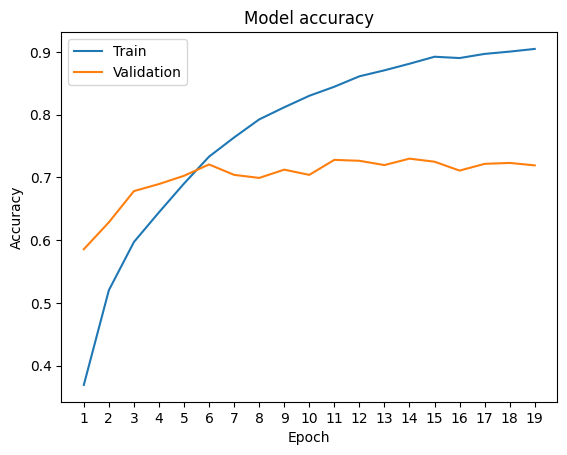

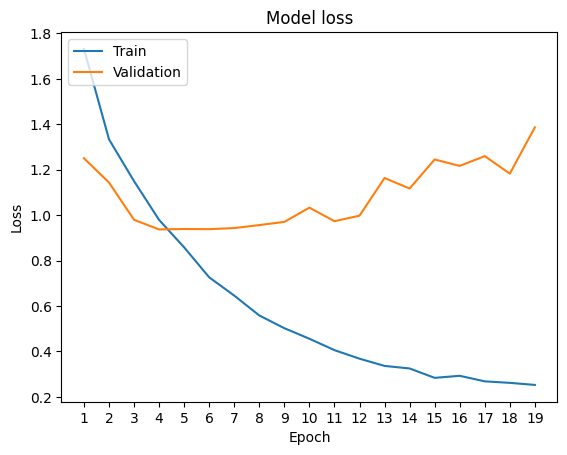

In [24]:
plot_training_history(history_basic)

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Deep Architecture</h3>
</div>

In [25]:
# Create train and validation generator
train_generator = create_train_generator('data/train', target_size=(128, 128), batch_size=32)
val_generator = create_val_generator('data/val', target_size=(128, 128), batch_size=32)

# early_stopper
early_stopper = create_early_stopper(monitor='val_accuracy', patience=5)

# CNN Model Structure with Input layer and additional Conv and MaxPooling layers
model_deep = Sequential([
    Input(shape=(128, 128, 3)),  # Adjusted input shape for 128x128 images
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),  # Additional Conv layer
    MaxPooling2D(2, 2),                      # Additional MaxPooling layer
    Flatten(),
    Dense(128, activation='relu'),  # Increased neurons in the Dense layer
    Dropout(0.5),
    Dense(10, activation='softmax')  # Adjusted for 10 classes with softmax
])

model_deep.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_deep = model_deep.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopper]
)

Found 8183 images belonging to 10 classes.
Found 2051 images belonging to 10 classes.
Epoch 1/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.3345 - loss: 1.8423 - val_accuracy: 0.5909 - val_loss: 1.2188
Epoch 2/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5648 - loss: 1.2411 - val_accuracy: 0.6455 - val_loss: 1.0254
Epoch 3/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.6525 - loss: 1.0146 - val_accuracy: 0.6782 - val_loss: 0.9472
Epoch 4/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.6984 - loss: 0.8620 - val_accuracy: 0.7123 - val_loss: 0.8484
Epoch 5/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.7488 - loss: 0.7242 - val_accuracy: 0.7138 - val_loss: 0.8686
Epoch 6/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.7912 - loss: 0.5924 - val_accuracy: 0.7075 - val_loss: 0.9312
Epoch 7/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.8150 - loss: 0.5197 - val_accuracy: 0.7240 - val_loss: 0.9752
Epoc

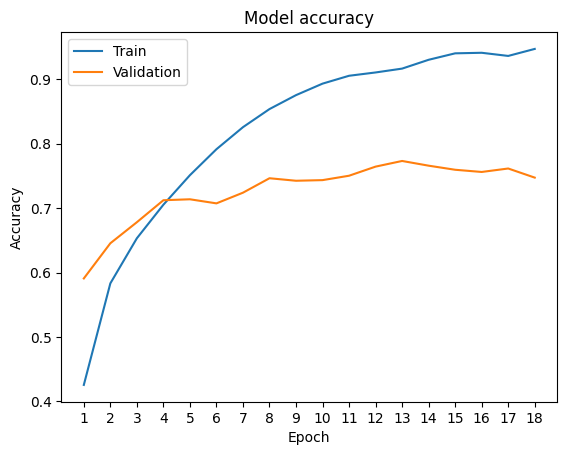

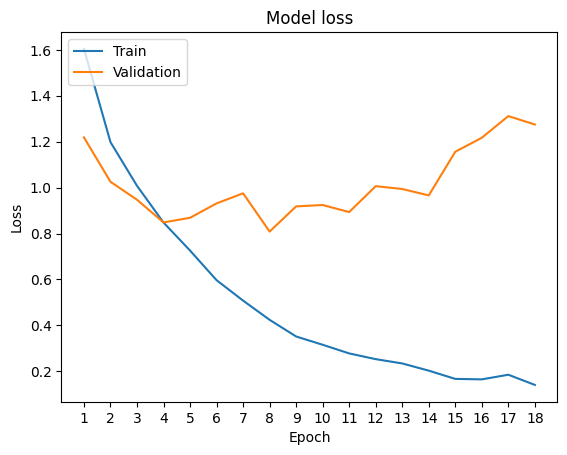

In [26]:
plot_training_history(history_deep)

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Double Convolution Layer Architecture</h3>
</div>

In [27]:
# Create train and validation generator
train_generator = create_train_generator('data/train', target_size=(128, 128), batch_size=32)
val_generator = create_val_generator('data/val', target_size=(128, 128), batch_size=32)

# early_stopper
early_stopper = create_early_stopper(monitor='val_accuracy', patience=5)


# CNN Model Structure with double convolution layers
model_doubleConv = Sequential([
    Input(shape=(128, 128, 3)),  # Adjusted input shape for 128x128 images
    Conv2D(32, (3, 3), activation='relu', padding='same'),  # 'same' padding to maintain dimension
    Conv2D(32, (3, 3), activation='relu', padding='same'),  # Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Additional Conv2D layer
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Output layer for 10 classes with softmax
])

model_doubleConv.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_doubleConv= model_doubleConv.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopper]
)

Found 8183 images belonging to 10 classes.
Found 2051 images belonging to 10 classes.
Epoch 1/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - accuracy: 0.3256 - loss: 1.9092 - val_accuracy: 0.5943 - val_loss: 1.1997
Epoch 2/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.5967 - loss: 1.1834 - val_accuracy: 0.6592 - val_loss: 1.0038
Epoch 3/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.6863 - loss: 0.9156 - val_accuracy: 0.6655 - val_loss: 1.0480
Epoch 4/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.7612 - loss: 0.7156 - val_accuracy: 0.6919 - val_loss: 0.9008
Epoch 5/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.8251 - loss: 0.5263 - val_accuracy: 0.7104 - val_loss: 0.9057
Epoch 6/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.8635 - loss: 0.3937 - val_accuracy: 0.7226 - val_loss: 0.9612
Epoch 7/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.9019 - loss: 0.2841 - val_accuracy: 0.7265 - val_loss: 1.0437
Epoc

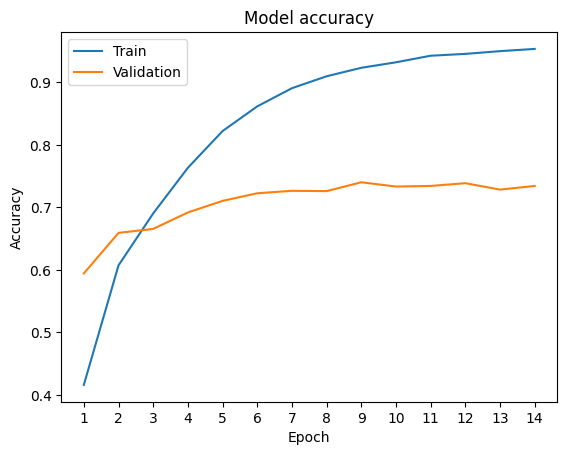

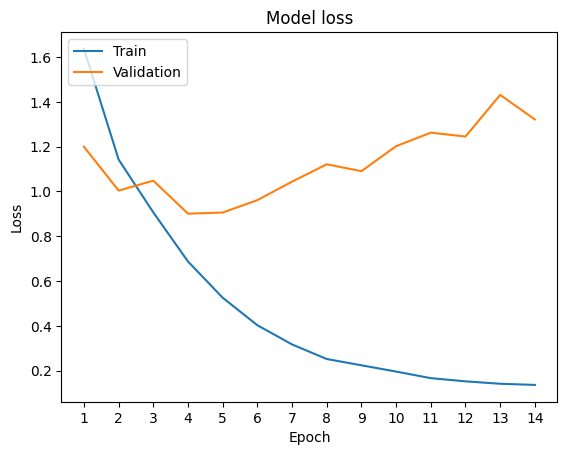

In [28]:
plot_training_history(history_doubleConv)

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Double Deep Architecture</h3>
</div>

In [29]:
# Create train and validation generator
train_generator = create_train_generator('data/train', target_size=(128, 128), batch_size=32)
val_generator = create_val_generator('data/val', target_size=(128, 128), batch_size=32)

# early_stopper
early_stopper = create_early_stopper(monitor='val_accuracy', patience=5)

model_doubleDeep = Sequential([
    Input(shape=(128, 128, 3)),  # Adjusted input shape for 128x128 images
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),  # Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Additional Conv layer
    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Additional Conv layer
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Output layer adjusted for 10 classes
])

# Compile the model
model_doubleDeep.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_doubleDeep = model_doubleDeep.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopper]
)

Found 8183 images belonging to 10 classes.
Found 2051 images belonging to 10 classes.
Epoch 1/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 25s 93ms/step - accuracy: 0.2682 - loss: 1.9978 - val_accuracy: 0.5314 - val_loss: 1.4053
Epoch 2/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.5017 - loss: 1.4283 - val_accuracy: 0.6119 - val_loss: 1.1633
Epoch 3/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.5948 - loss: 1.2092 - val_accuracy: 0.6660 - val_loss: 1.0000
Epoch 4/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.6464 - loss: 1.0075 - val_accuracy: 0.6967 - val_loss: 0.8912
Epoch 5/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.7143 - loss: 0.8444 - val_accuracy: 0.7328 - val_loss: 0.7653
Epoch 6/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.7635 - loss: 0.6992 - val_accuracy: 0.7499 - val_loss: 0.7595
Epoch 7/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.7872 - loss: 0.6096 - val_accuracy: 0.7489 - val_loss: 0.8290
Epoc

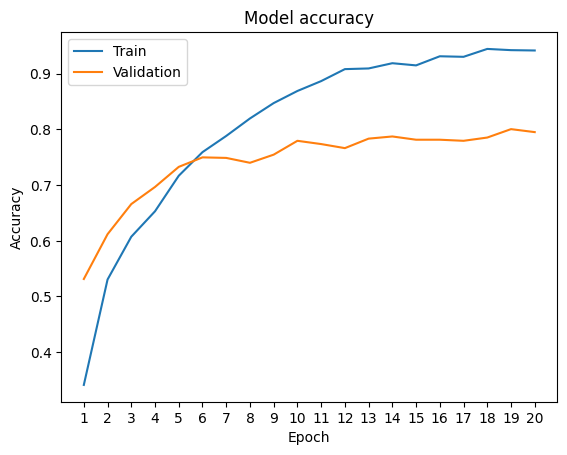

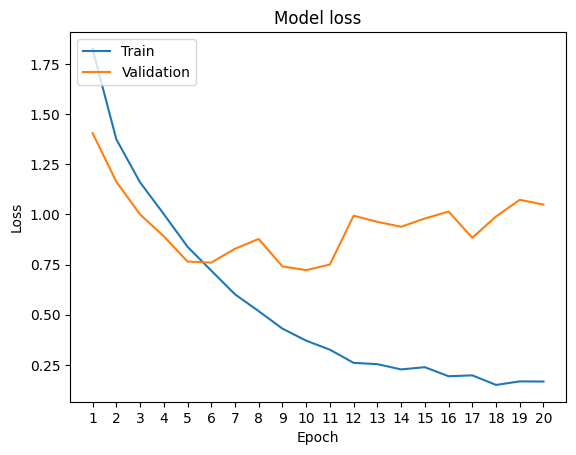

In [30]:
plot_training_history(history_doubleDeep)

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Optional Utilities</h3>
</div>

In [31]:
# Plot models
#plot_model(model_basic, to_file='images/model_basic.png', show_shapes=True, show_layer_names=True)
#plot_model(model_deep, to_file='images/model_deep.png', show_shapes=True, show_layer_names=True)
#plot_model(model_doubleConv, to_file='images/model_doubleConv.png', show_shapes=True, show_layer_names=True)
#plot_model(model_doubleDeep, to_file='images/model_doubleDeep.png', show_shapes=True, show_layer_names=True)
#print("All images finished")

In [38]:
# Save models
#model_basic.save('models/model_basic.keras')
#model_deep.save('models/model_deep.keras')
#model_doubleConv.save('models/model_doubleConv.keras')
#model_doubleDeep.save('models/model_doubleDeep.keras')

# Save history
#with open('history/model_basic.pkl', 'wb') as file:
#    pickle.dump(history_basic.history, file)

#with open('history/model_deep.pkl', 'wb') as file:
#    pickle.dump(history_deep.history, file)

#with open('history/model_doubleConv.pkl', 'wb') as file:
#    pickle.dump(history_doubleConv.history, file)

#with open('history/model_doubleDeep.pkl', 'wb') as file:
#    pickle.dump(history_doubleDeep.history, file)

In [33]:
# Load models
#model_basic = load_model('models/model_basic.keras')
#model_deep = load_model('models/model_deep.keras')
#model_doubleConv = load_model('models/model_doubleConv.keras')
#model_doubleDeep = load_model('models/model_doubleDeep.keras')

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Conclusion</h3>
</div>

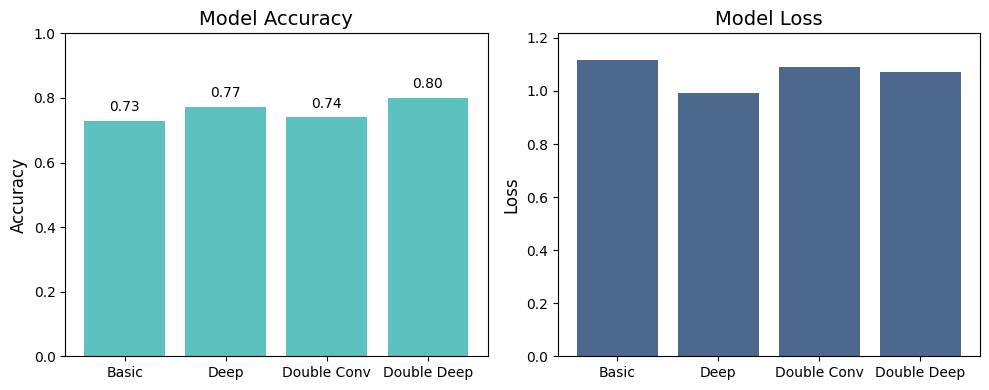

In [39]:
best = get_best_epoch_stats( ('Basic','Deep', 'Double Conv', 'Double Deep'), (history_basic, history_deep, history_doubleConv, history_doubleDeep)  )
plot_model_metrics(*best)

As we can see from the figures above, the Double Deep model outperforms the other three architectures (at least when we look at accuracy). We will therefore continue using the Double Deep architecture for the rest of this project. An even deeper model architecture could perhaps have resulted in even better results. But due to training time constraints, we will not attempt to train such a model here. Rather we will explore if the Deep model can be further improved by changing optimizer and introducing regularization.

<div style="background-color: #0B132B; padding: 25px; border-radius: 8px; border: 2px solid #6FFFE9; margin-top: 0;">
    <h3 style="color: #5BC0BE; text-align: center; font-size: 26px; margin-top: 30; margin-bottom: 30">Results and Analysis</h3>
</div>

In this part of the assignment, we will try out different techniques to improve the training or performance. There are many methods one can use to improve the performance of a CNN - such as trying out different optimizers, adding L2 regularization to the neurons in the network, altering the number of neurons dropped by the dropout layers, carrying out batch normalization and trying out different learning rates - to mention a few.

However, the time to train a CNN can be fairly long, and we will not be able in this assignment to test all of these techniques. We will focus on testing the impact of **optimizers** and **L2 regularization**. More specifically, we will test whether another optimizer - RMSprop - can produce better results, and we will see if L2 regularization factor of 0.001 and 0.01 can increase the accuracy. In all cases, we will use our top performing model, which is the Double Deep CNN model.

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Optimizers</h3>
</div>

In [42]:
# Create train and validation generator
train_generator = create_train_generator('data/train', target_size=(128, 128), batch_size=32)
val_generator = create_val_generator('data/val', target_size=(128, 128), batch_size=32)

# early_stopper
early_stopper = create_early_stopper(monitor='val_accuracy', patience=5)

model_doubleDeep_RMSprop = Sequential([
    Input(shape=(128, 128, 3)),  # Adjusted input shape for 128x128 images
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),  # Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Additional Conv layer
    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Additional Conv layer
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Output layer adjusted for 10 classes
])

# Compile the model
model_doubleDeep_RMSprop.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_doubleDeep_RMSprop = model_doubleDeep.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopper]
)

Found 8183 images belonging to 10 classes.
Found 2051 images belonging to 10 classes.
Epoch 1/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 24s 92ms/step - accuracy: 0.9682 - loss: 0.0882 - val_accuracy: 0.7840 - val_loss: 1.4071
Epoch 2/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.9577 - loss: 0.1257 - val_accuracy: 0.7694 - val_loss: 1.3598
Epoch 3/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.9648 - loss: 0.1036 - val_accuracy: 0.7767 - val_loss: 1.4436
Epoch 4/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.9697 - loss: 0.0817 - val_accuracy: 0.7947 - val_loss: 1.1867
Epoch 5/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 23s 92ms/step - accuracy: 0.9751 - loss: 0.0677 - val_accuracy: 0.7830 - val_loss: 1.4851
Epoch 6/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 24s 92ms/step - accuracy: 0.9712 - loss: 0.0819 - val_accuracy: 0.7952 - val_loss: 1.3308
Epoch 7/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 24s 92ms/step - accuracy: 0.9713 - loss: 0.0840 - val_accuracy: 0.7913 - val_loss: 1.3999
Epoc

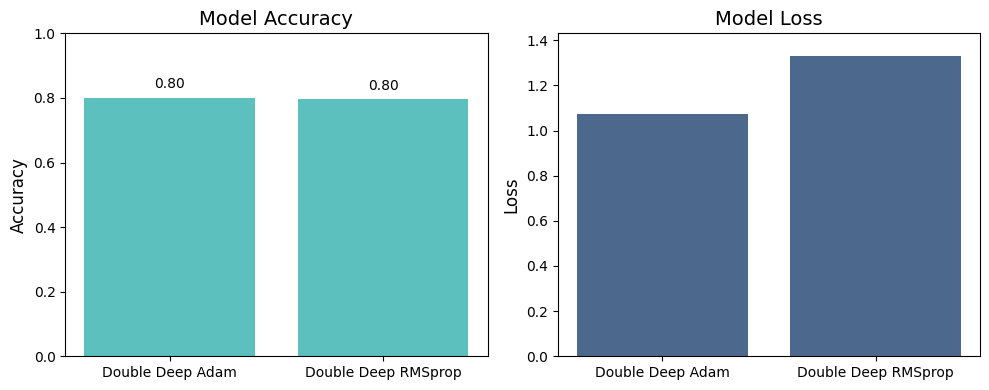

In [43]:
best = get_best_epoch_stats( ('Double Deep Adam', 'Double Deep RMSprop'), (history_doubleDeep, history_doubleDeep_RMSprop)  )
plot_model_metrics(*best)

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">L2 Regularization</h3>
</div>

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop

# Create train and validation generator
train_generator = create_train_generator('data/train', target_size=(128, 128), batch_size=32)
val_generator = create_val_generator('data/val', target_size=(128, 128), batch_size=32)

# early_stopper
early_stopper = create_early_stopper(monitor='val_accuracy', patience=5)

model_l2_001 = Sequential([
    Input(shape=(128, 128, 3)),  # Adjusted input shape for 128x128 images
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),  # Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),  # Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),  # Additional Conv layer
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),  # Additional Conv layer
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Output layer adjusted for 10 classes
])

# Compile the model
model_l2_001.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_l2_001 = model_l2_001.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopper]
)


Found 8183 images belonging to 10 classes.
Found 2051 images belonging to 10 classes.
Epoch 1/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 28s 100ms/step - accuracy: 0.2842 - loss: 2.2369 - val_accuracy: 0.4647 - val_loss: 1.7144
Epoch 2/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 24s 95ms/step - accuracy: 0.4983 - loss: 1.6186 - val_accuracy: 0.5461 - val_loss: 1.4752
Epoch 3/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 24s 95ms/step - accuracy: 0.5728 - loss: 1.4217 - val_accuracy: 0.6270 - val_loss: 1.2891
Epoch 4/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 24s 94ms/step - accuracy: 0.5880 - loss: 1.3695 - val_accuracy: 0.6485 - val_loss: 1.1751
Epoch 5/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 24s 94ms/step - accuracy: 0.6470 - loss: 1.2198 - val_accuracy: 0.6514 - val_loss: 1.2519
Epoch 6/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - accuracy: 0.6630 - loss: 1.1976 - val_accuracy: 0.6933 - val_loss: 1.1129
Epoch 7/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 25s 96ms/step - accuracy: 0.6952 - loss: 1.1024 - val_accuracy: 0.7079 - val_loss: 1.1115
Ep

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop

# Create train and validation generator
train_generator = create_train_generator('data/train', target_size=(128, 128), batch_size=32)
val_generator = create_val_generator('data/val', target_size=(128, 128), batch_size=32)

# early_stopper
early_stopper = create_early_stopper(monitor='val_accuracy', patience=5)

model_l2_0001 = Sequential([
    Input(shape=(128, 128, 3)),  # Adjusted input shape for 128x128 images
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)),
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)),  # Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)),  # Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)),  # Additional Conv layer
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)),  # Additional Conv layer
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Output layer adjusted for 10 classes
])

# Compile the model
model_l2_0001.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_l2_0001 = model_l2_0001.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopper]
)


Found 8183 images belonging to 10 classes.
Found 2051 images belonging to 10 classes.
Epoch 1/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - accuracy: 0.2844 - loss: 2.0035 - val_accuracy: 0.5188 - val_loss: 1.4089
Epoch 2/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 25s 96ms/step - accuracy: 0.4907 - loss: 1.4929 - val_accuracy: 0.6051 - val_loss: 1.1902
Epoch 3/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 25s 96ms/step - accuracy: 0.5680 - loss: 1.2804 - val_accuracy: 0.6202 - val_loss: 1.1678
Epoch 4/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 25s 96ms/step - accuracy: 0.6162 - loss: 1.1584 - val_accuracy: 0.6802 - val_loss: 1.0189
Epoch 5/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 25s 96ms/step - accuracy: 0.6763 - loss: 1.0262 - val_accuracy: 0.7026 - val_loss: 0.9332
Epoch 6/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step - accuracy: 0.7056 - loss: 0.9294 - val_accuracy: 0.7050 - val_loss: 0.9516
Epoch 7/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step - accuracy: 0.7212 - loss: 0.8783 - val_accuracy: 0.7231 - val_loss: 0.9523
Epo

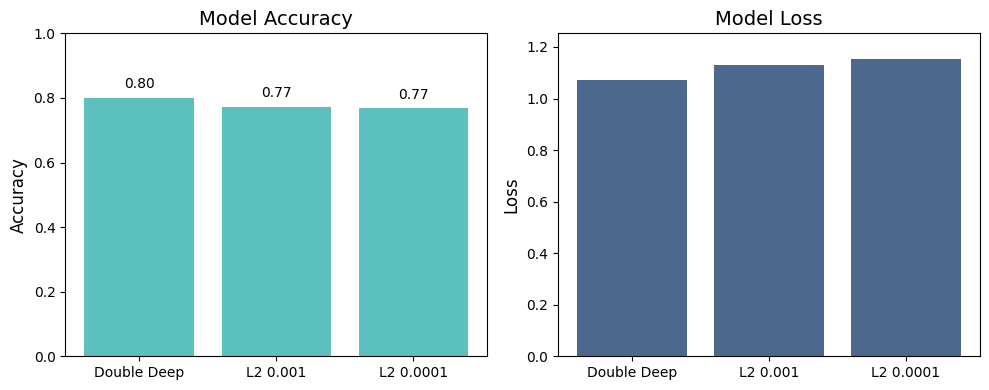

In [47]:
best = get_best_epoch_stats( ('Double Deep', 'L2 0.001', 'L2 0.0001'), (history_doubleDeep, history_l2_001, history_l2_0001)  )
plot_model_metrics(*best)

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Optional Utilities</h3>
</div>

In [48]:
#model_doubleDeep_RMSprop.save('models/model_doubleDeep_RMSprop.keras')
#model_l2_001.save('models/model_l2_001.keras')
#model_l2_0001.save('models/model_l2_0001.keras')

# Save history
#with open('history/model_doubleDeep_RMSprop.pkl', 'wb') as file:
#    pickle.dump(history_doubleDeep_RMSprop.history, file)

#with open('history/model_l2_001.pkl', 'wb') as file:
#    pickle.dump(history_l2_001.history, file)

#with open('history/model_l2_0001.pkl', 'wb') as file:
#    pickle.dump(history_l2_0001.history, file)

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Conclusion</h3>
</div>

In this part, we saw that ...

* Altering the optimizer to RMSprop did not improve model performance. Our inital model, which was using Adam, had the same accuracy, but with a slightly lower loss.
* L2 regularization did not lead to any improvement either. The combination of a lot of data, a dropout layer and a l2 regularization seem to have resulted in over-regularization and a model that was unable to fit the training data. This is the case even though we added a small about of l2 regularization.
* Therefore we keep our best model, which is the Double Deep.

<div style="background-color: #0B132B; padding: 25px; border-radius: 8px; border: 2px solid #6FFFE9; margin-top: 0;">
    <h3 style="color: #5BC0BE; text-align: center; font-size: 26px; margin-top: 30; margin-bottom: 30">Comparison with AlexNet and Inception-ResNet-v2</h3>
</div>

In this last part of the project, we will compare our best performing model - the Double Deep - with two of the models used in the paper by Llamas et al. (2017) - Alex net and Inception-Res-v2. Alex net is a model that among others utilize stacked convolutional layers, ReLU activations and dropout for regularization. It achieved a remarkable performance on the ImageNet dataset in 2012. In our case, and also more commonly, Alex net is not pre-trained. Inception-ResNet-v2, on the other hand, is a model that is pre-trained on imagenet data, which conisists of 1000 object classes and contains 1,281,167 training images. In addition, it uses parallel convolutional layers of different sizes to capture diverse features, with the residual connections from ResNet that allow for deeper networks by facilitating gradient flow. 

**References**

Llamas J, M. Lerones P, Medina R, Zalama E, Gómez-García-Bermejo J. Classification of Architectural Heritage Images Using Deep Learning Techniques. Applied Sciences. 2017; 7(10):992. https://doi.org/10.3390/app7100992

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">AlexNet</h3>
</div>

In [55]:
# Create train and validation generator
train_generator = create_train_generator('data/train', target_size=(128, 128), batch_size=32)
val_generator = create_val_generator('data/val', target_size=(128, 128), batch_size=32)

# early_stopper
early_stopper = create_early_stopper(monitor='val_accuracy', patience=5)

# Adapted AlexNet architecture for 128x128 input images and 10 output classes
model_alexnet_adapted = Sequential([
    # First convolutional layer
    Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(128, 128, 3), padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    
    # Second convolutional layer
    Conv2D(filters=256, kernel_size=(5, 5), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    
    # Third convolutional layer
    Conv2D(filters=384, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    
    # Fourth convolutional layer
    Conv2D(filters=384, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    
    # Fifth convolutional layer
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    
    # Flatten the network before fully connected layers
    Flatten(),
    
    # First fully connected layer
    Dense(4096, activation='relu'),
    Dropout(0.5),
    
    # Second fully connected layer
    Dense(4096, activation='relu'),
    Dropout(0.5),
    
    # Output layer with 10 units for the 10 classes
    Dense(10, activation='softmax')
])

# Compile the model
model_alexnet_adapted.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
#model_alexnet_adapted.summary()

# Train the model
history_alexnet_adapted = model_alexnet_adapted.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopper]
)

Found 8183 images belonging to 10 classes.
Found 2051 images belonging to 10 classes.
Epoch 1/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 65s 180ms/step - accuracy: 0.2489 - loss: 4.6808 - val_accuracy: 0.2706 - val_loss: 2.0335
Epoch 2/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 31s 120ms/step - accuracy: 0.3256 - loss: 1.8786 - val_accuracy: 0.2550 - val_loss: 2.1023
Epoch 3/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 31s 122ms/step - accuracy: 0.3294 - loss: 1.8723 - val_accuracy: 0.2028 - val_loss: 2.0922
Epoch 4/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step - accuracy: 0.3792 - loss: 1.7128 - val_accuracy: 0.1902 - val_loss: 3.1237
Epoch 5/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step - accuracy: 0.5114 - loss: 1.4615 - val_accuracy: 0.2516 - val_loss: 4.0222
Epoch 6/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 31s 121ms/step - accuracy: 0.6077 - loss: 1.2018 - val_accuracy: 0.5076 - val_loss: 1.6905
Epoch 7/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 31s 119ms/step - accuracy: 0.6634 - loss: 1.0585 - val_accuracy: 0.4330 - val_loss: 1.80

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Inception-ResNet-v2</h3>
</div>

In [56]:
# Create train and validation generator
train_generator = create_train_generator('data/train', target_size=(128, 128), batch_size=32)
val_generator = create_val_generator('data/val', target_size=(128, 128), batch_size=32)

# early_stopper
early_stopper = create_early_stopper(monitor='val_accuracy', patience=5)

def create_inception_resnet_v2(input_shape=(128, 128, 3), num_classes=10):
    # Load Inception-ResNet-v2 with pre-trained ImageNet weights, excluding the top layer
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

    # Freeze the layers of the base model to prevent them from being updated during training
    for layer in base_model.layers:
        layer.trainable = False

    # Add new classifier layers
    x = GlobalAveragePooling2D()(base_model.output)  # Add a global spatial average pooling layer
    x = Dense(1024, activation='relu')(x)            # Add a fully-connected layer
    predictions = Dense(num_classes, activation='softmax')(x)  # Add a softmax layer for 10 classes

    # Construct the full model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the Inception-ResNet-v2 model
model_inception_resnet_v2 = create_inception_resnet_v2()

# Model summary
#model_inception_resnet_v2.summary()

# Train the model
history_inception_resnet_v2 = model_inception_resnet_v2.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopper]
)

Found 8183 images belonging to 10 classes.
Found 2051 images belonging to 10 classes.
Epoch 1/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 161s 546ms/step - accuracy: 0.7450 - loss: 1.8359 - val_accuracy: 0.8859 - val_loss: 0.3158
Epoch 2/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 62s 240ms/step - accuracy: 0.9026 - loss: 0.3100 - val_accuracy: 0.9059 - val_loss: 0.3070
Epoch 3/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 56s 219ms/step - accuracy: 0.9214 - loss: 0.2505 - val_accuracy: 0.9113 - val_loss: 0.2643
Epoch 4/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 56s 219ms/step - accuracy: 0.9327 - loss: 0.2009 - val_accuracy: 0.9025 - val_loss: 0.3011
Epoch 5/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 50s 194ms/step - accuracy: 0.9272 - loss: 0.2099 - val_accuracy: 0.9069 - val_loss: 0.2843
Epoch 6/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 51s 198ms/step - accuracy: 0.9413 - loss: 0.1690 - val_accuracy: 0.9113 - val_loss: 0.2884
Epoch 7/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 51s 197ms/step - accuracy: 0.9460 - loss: 0.1519 - val_accuracy: 0.9093 - val_loss: 0.2

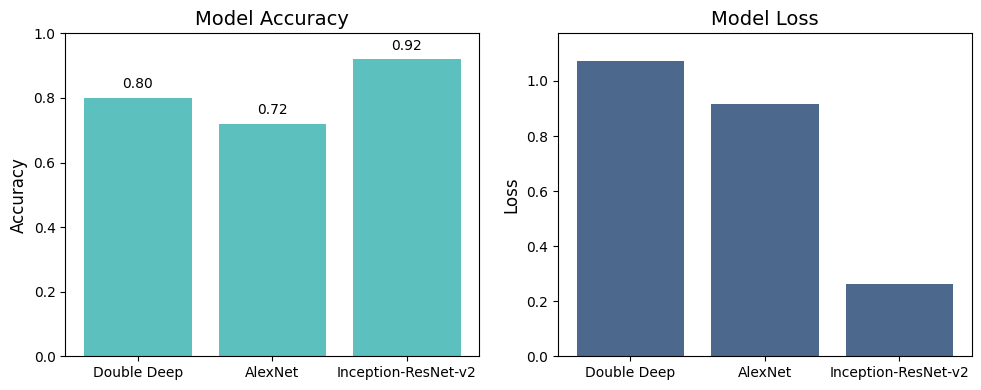

In [58]:
best = get_best_epoch_stats( ('Double Deep', 'AlexNet', 'Inception-ResNet-v2'), (history_doubleDeep, history_model_alexnet_adapted, history_model_inception_resnet_v2)  )
plot_model_metrics(*best)

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Optional Utilities</h3>
</div>

In [59]:
model_alexnet_adapted.save('models/model_alexnet_adapted.keras')
model_inception_resnet_v2.save('models/model_inception_resnet_v2.keras')

# Save history
with open('history/model_alexnet_adapted.pkl', 'wb') as file:
    pickle.dump(history_alexnet_adapted.history, file)

with open('history/model_inception_resnet_v2.pkl', 'wb') as file:
    pickle.dump(history_inception_resnet_v2.history, file)

<div style="background-color: #0B132B; padding: 25px; border-radius: 8px; border: 2px solid #6FFFE9; margin-top: 0;">
    <h3 style="color: #5BC0BE; text-align: center; font-size: 26px; margin-top: 30; margin-bottom: 30">Conclusion</h3>
</div>

In this assignment, we have seen that it is possible to build a CNN model that can classify architectural heritage elements into classes with a reasonably good accuracy. Our top performing model classified architectural heritage elements with an accuracy of about 80%. Considering that the elements could belong to 10 different categories, this is not bad at all. The statistical accuracy for a random classification would have been 10%. Apart from that we found that:

* Architecture seem to be very important compared to more conventional hyper parameter tuning and regularization.
* Both depth and double convolution layers seem both to add positively to performance and the combinaiton produces very good results.
* It is espacially challenging to try out many combinations of architecture and hyper parameter tunings on CNNs due to their long traing times.
* Pre-trained models, such as InceptionResNet v2, tend to outperform model which have not been trained in advance. In our case, the InceptionResNet model managed to classify 92% of the elements correctly.